# Yuanyang(Ian) Zheng yz9fy

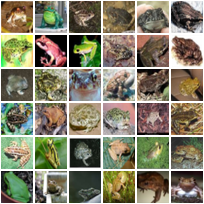

{
  data : ByteTensor - size: 50000x3x32x32
  label : ByteTensor - size: 50000
}
{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [3]:
require 'image'
-- The default tensor type in Torch is DoubleTensor, but we generally only need Float precision.
torch.setdefaulttensortype('torch.FloatTensor')

-- Load data.
trainset = torch.load('cifar10-train.t7') -- training images.
valset = torch.load('cifar10-val.t7')  -- validation set used to evaluate the model and tune parameters.
trainset.label = trainset.label + 1
valset.label = valset.label + 1
classes = {'airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck'}

-- Let's show all images of frogs.
class2ids = {}  -- Build a mapping between object names and class ids.
-- Remember that tables in lua are similar to (key,value) collections e.g. hashmaps.
for k,v in pairs(classes) do class2ids[v] = k end

-- Retrieve the frog class number.
object_class_id = class2ids['frog'] -- try changing this to visualize some images from other categories.
-- Put all images of frogs into a table.
objects = {}
local object_indices = trainset.label:eq(object_class_id):nonzero():squeeze()
for i = 1, 36 do  -- Let's show the first 36 frogs.
    table.insert(objects, trainset.data[object_indices[i]])
end

-- Plot the images of frogs using itorch.image
itorch.image(objects)
print(trainset) -- View what is inside the training set.
print(valset)  -- View what is inside the validation set.

In [4]:
-- Make the data a FloatTensor.
trainset.normdata = trainset.data:clone():float()
valset.normdata = valset.data:clone():float()
cifarMean = {trainset.normdata[{{}, {1}, {}, {}}]:mean(),
             trainset.normdata[{{}, {2}, {}, {}}]:mean(),
             trainset.normdata[{{}, {3}, {}, {}}]:mean()}

cifarStd = {trainset.normdata[{{}, {1}, {}, {}}]:std(),
            trainset.normdata[{{}, {2}, {}, {}}]:std(),
            trainset.normdata[{{}, {3}, {}, {}}]:std()}

-- Print the mean and std value for each channel.
print(cifarMean)
print(cifarStd)

-- Now normalize the training and validation data.
for i  = 1, 3 do
    -- Subtracting the mean on each channel makes the values roughly between -128 and 128.
    trainset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    valset.normdata[{{}, {i}, {}, {}}]:add(-cifarMean[i])
    -- Dividing the std on each channel makes the values roughly between -1 and 1.
    trainset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
    valset.normdata[{{}, {i}, {}, {}}]:div(cifarStd[i])
end


{
  1 : 125.30691804687
  2 : 122.95039414062
  3 : 113.86538318359
}
{
  1 : 62.993219892912
  2 : 62.088708246722
  3 : 66.704900292063
}


In [5]:
require 'nn'  -- This library contains the classes we will need (Linear, LogSoftMax, ClassNLLCriterion)

local model = nn.Sequential()   -- Just a container of sequential operations.
model:add(nn.View(32 * 32 * 3))  -- This View layer vectorizes the images from a 3,32,32 tensor to a 3*32*32 vector.
model:add(nn.Linear(32 * 32 * 3, 10))  -- Linear transformation y = Wx + b
model:add(nn.LogSoftMax())  -- Log SoftMax function.

local criterion = nn.ClassNLLCriterion() -- Negative log-likelihood criterion.
-- params is a flat vector with the concatenation of all the parameters inside model.
-- gradParams is a flat vector with the concatenation of all the gradients of parameters inside the model.
-- These two variables also merely point to the internal individual parameters in each layer of the module.

function trainModel(model, opt, features, preprocessFn)
    -- Get all the parameters (and gradients) of the model in a single vector.
    local params, gradParams = model:getParameters()

    local opt = opt or {}
    local batchSize = opt.batchSize or 64  -- The bigger the batch size the most accurate the gradients.
    local learningRate = opt.learningRate or 0.001  -- This is the learning rate parameter often referred to as lambda.
    local momentumRate = opt.momentumRate or 0.9
    local numEpochs = opt.numEpochs or 3
    local velocityParams = torch.zeros(gradParams:size())
    local train_features, val_features
    if preprocessFn then
        train_features = trainset.data:float():div(255)
        val_features = valset.data:float():div(255)
    else
        train_features = (features and features.train_features) or trainset.normdata
        val_features = (features and features.val_features) or valset.normdata
    end
    -- Go over the training data this number of times.
    for epoch = 1, numEpochs do
        local sum_loss = 0
        local correct = 0
        
        -- Run over the training set samples.
        model:training()
        for i = 1, trainset.normdata:size(1) / batchSize do
            
            -- 1. Sample a batch.
            local inputs
            if preprocessFn then
                inputs = torch.Tensor(batchSize, 3, 224, 224)
            else
                inputs = (features and torch.Tensor(batchSize, 4096)) or torch.Tensor(batchSize, 3, 32, 32)
            end
            local labels = torch.Tensor(batchSize)
            for bi = 1, batchSize do
                local rand_id = torch.random(1, train_features:size(1))
                if preprocessFn then
                    inputs[bi] = preprocessFn(train_features[rand_id])
                else
                    inputs[bi] = train_features[rand_id]
                end
                labels[bi] = trainset.label[rand_id]
            end
            -- 2. Perform the forward pass (prediction mode).
            local predictions = model:forward(inputs)
            
            -- 3. Evaluate results.
            for i = 1, predictions:size(1) do
                local _, predicted_label = predictions[i]:max(1)
                if predicted_label[1] == labels[i] then correct = correct + 1 end
            end
            sum_loss = sum_loss + criterion:forward(predictions, labels)

            -- 4. Perform the backward pass (compute derivatives).
            -- This zeroes-out all the parameters inside the model pointed by variable params.
            model:zeroGradParameters()
            -- This internally computes the gradients with respect to the parameters pointed by gradParams.
            local gradPredictions = criterion:backward(predictions, labels)
            model:backward(inputs, gradPredictions)

            -- 5. Perform the SGD update.
            velocityParams:mul(momentumRate)
            velocityParams:add(learningRate, gradParams)
            params:add(-1, velocityParams)

            if i % 100 == 0 then  -- Print this every five thousand iterations.
                print(('train epoch=%d, iteration=%d, avg-loss=%.6f, avg-accuracy = %.2f')
                    :format(epoch, i, sum_loss / i, correct / (i * batchSize)))
            end
        end

        -- Run over the validation set for evaluation.
        local validation_accuracy = 0
        local nBatches = val_features:size(1) / batchSize
        model:evaluate()
        for i = 1, nBatches do
            
            -- 1. Sample a batch.
            if preprocessFn then
                inputs = torch.Tensor(batchSize, 3, 224, 224)
            else
                inputs = (features and torch.Tensor(batchSize, 4096)) or torch.Tensor(batchSize, 3, 32, 32)
            end
            local labels = torch.Tensor(batchSize)
            for bi = 1, batchSize do
                local rand_id = torch.random(1, val_features:size(1))
                if preprocessFn then
                    inputs[bi] = preprocessFn(val_features[rand_id])
                else
                    inputs[bi] = val_features[rand_id]
                end
                labels[bi] = valset.label[rand_id]
            end

            -- 2. Perform the forward pass (prediction mode).
            local predictions = model:forward(inputs)
            
            -- 3. evaluate results.
            for i = 1, predictions:size(1) do
                local _, predicted_label = predictions[i]:max(1)
                if predicted_label[1] == labels[i] then validation_accuracy = validation_accuracy + 1 end
            end
        end
        validation_accuracy = validation_accuracy / (nBatches * batchSize)
        print(('\nvalidation accuracy at epoch = %d is %.4f'):format(epoch, validation_accuracy))
    end
end

trainModel(model)

train epoch=1, iteration=100, avg-loss=1.988904, avg-accuracy = 0.30	


train epoch=1, iteration=200, avg-loss=1.939553, avg-accuracy = 0.32	

train epoch=1, iteration=300, avg-loss=1.911315, avg-accuracy = 0.33	


train epoch=1, iteration=400, avg-loss=1.887507, avg-accuracy = 0.34	


train epoch=1, iteration=500, avg-loss=1.873515, avg-accuracy = 0.35	


train epoch=1, iteration=600, avg-loss=1.860394, avg-accuracy = 0.35	


train epoch=1, iteration=700, avg-loss=1.853981, avg-accuracy = 0.36	



validation accuracy at epoch = 1 is 0.3822	

train epoch=2, iteration=100, avg-loss=1.781417, avg-accuracy = 0.40	


train epoch=2, iteration=200, avg-loss=1.785638, avg-accuracy = 0.39	


train epoch=2, iteration=300, avg-loss=1.774802, avg-accuracy = 0.39	


train epoch=2, iteration=400, avg-loss=1.776184, avg-accuracy = 0.39	


train epoch=2, iteration=500, avg-loss=1.774516, avg-accuracy = 0.39	


train epoch=2, iteration=600, avg-loss=1.770718, avg-accuracy = 0.39	

train epoch=2, iteration=700, avg-loss=1.768806, avg-accuracy = 0.40	



validation accuracy at epoch = 2 is 0.3739	


train epoch=3, iteration=100, avg-loss=1.737757, avg-accuracy = 0.41	


train epoch=3, iteration=200, avg-loss=1.741209, avg-accuracy = 0.40	


train epoch=3, iteration=300, avg-loss=1.737229, avg-accuracy = 0.41	

train epoch=3, iteration=400, avg-loss=1.736679, avg-accuracy = 0.41	


train epoch=3, iteration=500, avg-loss=1.738329, avg-accuracy = 0.41	


train epoch=3, iteration=600, avg-loss=1.740232, avg-accuracy = 0.41	


train epoch=3, iteration=700, avg-loss=1.739285, avg-accuracy = 0.41	



validation accuracy at epoch = 3 is 0.3622	


In [6]:
local model = nn.Sequential()   -- Just a container of sequential operations.
model:add(nn.View(32 * 32 * 3))  -- This View layer vectorizes the images from a 3,32,32 tensor to a 3*32*32 vector.
model:add(nn.Linear(32 * 32 * 3, 500))  -- Linear transformation y = Wx + b
model:add(nn.ReLU())
model:add(nn.Linear(500, 10))  -- Linear transformation y = Wx + b
model:add(nn.LogSoftMax())  -- Log SoftMax function.

trainModel(model) -- Reuse our training code from earlier.


train epoch=1, iteration=100, avg-loss=2.044274, avg-accuracy = 0.27	


train epoch=1, iteration=200, avg-loss=1.946308, avg-accuracy = 0.31	


train epoch=1, iteration=300, avg-loss=1.876882, avg-accuracy = 0.34	


train epoch=1, iteration=400, avg-loss=1.834868, avg-accuracy = 0.35	

train epoch=1, iteration=500, avg-loss=1.797961, avg-accuracy = 0.37	


train epoch=1, iteration=600, avg-loss=1.771219, avg-accuracy = 0.38	


train epoch=1, iteration=700, avg-loss=1.747808, avg-accuracy = 0.39	



validation accuracy at epoch = 1 is 0.4376	


train epoch=2, iteration=100, avg-loss=1.598174, avg-accuracy = 0.45	


train epoch=2, iteration=200, avg-loss=1.565042, avg-accuracy = 0.46	


train epoch=2, iteration=300, avg-loss=1.557756, avg-accuracy = 0.46	

train epoch=2, iteration=400, avg-loss=1.548366, avg-accuracy = 0.46	


train epoch=2, iteration=500, avg-loss=1.542780, avg-accuracy = 0.47	


train epoch=2, iteration=600, avg-loss=1.536659, avg-accuracy = 0.47	


train epoch=2, iteration=700, avg-loss=1.529980, avg-accuracy = 0.47	



validation accuracy at epoch = 2 is 0.4595	


train epoch=3, iteration=100, avg-loss=1.434766, avg-accuracy = 0.51	


train epoch=3, iteration=200, avg-loss=1.445537, avg-accuracy = 0.50	


train epoch=3, iteration=300, avg-loss=1.445750, avg-accuracy = 0.50	


train epoch=3, iteration=400, avg-loss=1.444470, avg-accuracy = 0.50	


train epoch=3, iteration=500, avg-loss=1.444220, avg-accuracy = 0.50	


train epoch=3, iteration=600, avg-loss=1.442506, avg-accuracy = 0.50	


train epoch=3, iteration=700, avg-loss=1.436036, avg-accuracy = 0.51	



validation accuracy at epoch = 3 is 0.4925	


In [7]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))   -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.01 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5
trainModel(model, opt)

train epoch=1, iteration=100, avg-loss=2.268732, avg-accuracy = 0.15	


train epoch=1, iteration=200, avg-loss=2.137752, avg-accuracy = 0.20	


train epoch=1, iteration=300, avg-loss=2.032918, avg-accuracy = 0.24	


train epoch=1, iteration=400, avg-loss=1.957368, avg-accuracy = 0.27	


train epoch=1, iteration=500, avg-loss=1.897510, avg-accuracy = 0.29	


train epoch=1, iteration=600, avg-loss=1.845615, avg-accuracy = 0.31	


train epoch=1, iteration=700, avg-loss=1.799219, avg-accuracy = 0.33	


train epoch=1, iteration=800, avg-loss=1.763979, avg-accuracy = 0.35	


train epoch=1, iteration=900, avg-loss=1.734356, avg-accuracy = 0.36	


train epoch=1, iteration=1000, avg-loss=1.707425, avg-accuracy = 0.37	


train epoch=1, iteration=1100, avg-loss=1.681114, avg-accuracy = 0.38	


train epoch=1, iteration=1200, avg-loss=1.661282, avg-accuracy = 0.39	


train epoch=1, iteration=1300, avg-loss=1.641681, avg-accuracy = 0.40	


train epoch=1, iteration=1400, avg-loss=1.625048, avg-accuracy = 0.40	


train epoch=1, iteration=1500, avg-loss=1.607777, avg-accuracy = 0.41	



validation accuracy at epoch = 1 is 0.5138	


train epoch=2, iteration=100, avg-loss=1.350647, avg-accuracy = 0.52	


train epoch=2, iteration=200, avg-loss=1.343463, avg-accuracy = 0.52	


train epoch=2, iteration=300, avg-loss=1.358569, avg-accuracy = 0.51	


train epoch=2, iteration=400, avg-loss=1.346130, avg-accuracy = 0.52	


train epoch=2, iteration=500, avg-loss=1.334458, avg-accuracy = 0.52	


train epoch=2, iteration=600, avg-loss=1.323373, avg-accuracy = 0.53	


train epoch=2, iteration=700, avg-loss=1.315074, avg-accuracy = 0.53	


train epoch=2, iteration=800, avg-loss=1.306946, avg-accuracy = 0.53	


train epoch=2, iteration=900, avg-loss=1.299701, avg-accuracy = 0.54	


train epoch=2, iteration=1000, avg-loss=1.290840, avg-accuracy = 0.54	


train epoch=2, iteration=1100, avg-loss=1.286877, avg-accuracy = 0.54	


train epoch=2, iteration=1200, avg-loss=1.279690, avg-accuracy = 0.54	


train epoch=2, iteration=1300, avg-loss=1.278683, avg-accuracy = 0.54	


train epoch=2, iteration=1400, avg-loss=1.270861, avg-accuracy = 0.55	


train epoch=2, iteration=1500, avg-loss=1.264335, avg-accuracy = 0.55	



validation accuracy at epoch = 2 is 0.5333	


train epoch=3, iteration=100, avg-loss=1.196475, avg-accuracy = 0.58	


train epoch=3, iteration=200, avg-loss=1.188947, avg-accuracy = 0.58	


train epoch=3, iteration=300, avg-loss=1.186337, avg-accuracy = 0.58	


train epoch=3, iteration=400, avg-loss=1.182559, avg-accuracy = 0.58	


train epoch=3, iteration=500, avg-loss=1.181088, avg-accuracy = 0.58	


train epoch=3, iteration=600, avg-loss=1.179830, avg-accuracy = 0.58	

train epoch=3, iteration=700, avg-loss=1.174525, avg-accuracy = 0.58	


train epoch=3, iteration=800, avg-loss=1.167078, avg-accuracy = 0.59	


train epoch=3, iteration=900, avg-loss=1.165731, avg-accuracy = 0.59	


train epoch=3, iteration=1000, avg-loss=1.161043, avg-accuracy = 0.59	


train epoch=3, iteration=1100, avg-loss=1.158442, avg-accuracy = 0.59	


train epoch=3, iteration=1200, avg-loss=1.155723, avg-accuracy = 0.59	


train epoch=3, iteration=1300, avg-loss=1.154876, avg-accuracy = 0.59	


train epoch=3, iteration=1400, avg-loss=1.153870, avg-accuracy = 0.59	


train epoch=3, iteration=1500, avg-loss=1.150281, avg-accuracy = 0.59	



validation accuracy at epoch = 3 is 0.5617	


train epoch=4, iteration=100, avg-loss=1.078776, avg-accuracy = 0.63	


train epoch=4, iteration=200, avg-loss=1.089264, avg-accuracy = 0.62	


train epoch=4, iteration=300, avg-loss=1.088997, avg-accuracy = 0.62	


train epoch=4, iteration=400, avg-loss=1.091781, avg-accuracy = 0.62	


train epoch=4, iteration=500, avg-loss=1.091368, avg-accuracy = 0.62	


train epoch=4, iteration=600, avg-loss=1.085582, avg-accuracy = 0.62	

train epoch=4, iteration=700, avg-loss=1.082228, avg-accuracy = 0.62	


train epoch=4, iteration=800, avg-loss=1.080601, avg-accuracy = 0.62	


train epoch=4, iteration=900, avg-loss=1.077350, avg-accuracy = 0.62	


train epoch=4, iteration=1000, avg-loss=1.072768, avg-accuracy = 0.62	


train epoch=4, iteration=1100, avg-loss=1.072255, avg-accuracy = 0.62	


train epoch=4, iteration=1200, avg-loss=1.069110, avg-accuracy = 0.62	


train epoch=4, iteration=1300, avg-loss=1.065940, avg-accuracy = 0.62	


train epoch=4, iteration=1400, avg-loss=1.065501, avg-accuracy = 0.62	


train epoch=4, iteration=1500, avg-loss=1.065221, avg-accuracy = 0.62	



validation accuracy at epoch = 4 is 0.5748	


train epoch=5, iteration=100, avg-loss=1.041205, avg-accuracy = 0.64	


train epoch=5, iteration=200, avg-loss=1.051379, avg-accuracy = 0.64	


train epoch=5, iteration=300, avg-loss=1.060602, avg-accuracy = 0.63	


train epoch=5, iteration=400, avg-loss=1.045664, avg-accuracy = 0.64	


train epoch=5, iteration=500, avg-loss=1.044242, avg-accuracy = 0.64	


train epoch=5, iteration=600, avg-loss=1.041696, avg-accuracy = 0.64	

train epoch=5, iteration=700, avg-loss=1.046213, avg-accuracy = 0.64	


train epoch=5, iteration=800, avg-loss=1.043398, avg-accuracy = 0.64	


train epoch=5, iteration=900, avg-loss=1.039455, avg-accuracy = 0.64	


train epoch=5, iteration=1000, avg-loss=1.040298, avg-accuracy = 0.64	


train epoch=5, iteration=1100, avg-loss=1.040609, avg-accuracy = 0.64	


train epoch=5, iteration=1200, avg-loss=1.041651, avg-accuracy = 0.64	


train epoch=5, iteration=1300, avg-loss=1.041012, avg-accuracy = 0.64	


train epoch=5, iteration=1400, avg-loss=1.037359, avg-accuracy = 0.64	


train epoch=5, iteration=1500, avg-loss=1.039071, avg-accuracy = 0.64	



validation accuracy at epoch = 5 is 0.5898	


In [5]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.SpatialBatchNormalization(8, 1e-3))  -- BATCH NORMALIZATION LAYER.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.SpatialBatchNormalization(16, 1e-3))  -- BATCH NORMALIZATION LAYER.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))    -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.02 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5
trainModel(model, opt)  -- This will take a while!

train epoch=1, iteration=100, avg-loss=2.094354, avg-accuracy = 0.22	


train epoch=1, iteration=200, avg-loss=1.965842, avg-accuracy = 0.26	


train epoch=1, iteration=300, avg-loss=1.890007, avg-accuracy = 0.29	


train epoch=1, iteration=400, avg-loss=1.830742, avg-accuracy = 0.32	


train epoch=1, iteration=500, avg-loss=1.777298, avg-accuracy = 0.34	


train epoch=1, iteration=600, avg-loss=1.737983, avg-accuracy = 0.35	


train epoch=1, iteration=700, avg-loss=1.706787, avg-accuracy = 0.36	


train epoch=1, iteration=800, avg-loss=1.681023, avg-accuracy = 0.38	


train epoch=1, iteration=900, avg-loss=1.656192, avg-accuracy = 0.39	


train epoch=1, iteration=1000, avg-loss=1.634492, avg-accuracy = 0.40	


train epoch=1, iteration=1100, avg-loss=1.616688, avg-accuracy = 0.41	


train epoch=1, iteration=1200, avg-loss=1.600121, avg-accuracy = 0.41	

train epoch=1, iteration=1300, avg-loss=1.579717, avg-accuracy = 0.42	


train epoch=1, iteration=1400, avg-loss=1.566048, avg-accuracy = 0.43	


train epoch=1, iteration=1500, avg-loss=1.549517, avg-accuracy = 0.43	



validation accuracy at epoch = 1 is 0.5339	


train epoch=2, iteration=100, avg-loss=1.333777, avg-accuracy = 0.52	


train epoch=2, iteration=200, avg-loss=1.320087, avg-accuracy = 0.53	


train epoch=2, iteration=300, avg-loss=1.306534, avg-accuracy = 0.54	


train epoch=2, iteration=400, avg-loss=1.293492, avg-accuracy = 0.54	


train epoch=2, iteration=500, avg-loss=1.289740, avg-accuracy = 0.54	


train epoch=2, iteration=600, avg-loss=1.281590, avg-accuracy = 0.54	


train epoch=2, iteration=700, avg-loss=1.275702, avg-accuracy = 0.55	


train epoch=2, iteration=800, avg-loss=1.268211, avg-accuracy = 0.55	


train epoch=2, iteration=900, avg-loss=1.261265, avg-accuracy = 0.55	


train epoch=2, iteration=1000, avg-loss=1.255078, avg-accuracy = 0.55	


train epoch=2, iteration=1100, avg-loss=1.248679, avg-accuracy = 0.56	


train epoch=2, iteration=1200, avg-loss=1.241724, avg-accuracy = 0.56	


train epoch=2, iteration=1300, avg-loss=1.235804, avg-accuracy = 0.56	


train epoch=2, iteration=1400, avg-loss=1.230984, avg-accuracy = 0.56	


train epoch=2, iteration=1500, avg-loss=1.223265, avg-accuracy = 0.57	



validation accuracy at epoch = 2 is 0.5851	


train epoch=3, iteration=100, avg-loss=1.121500, avg-accuracy = 0.60	


train epoch=3, iteration=200, avg-loss=1.145462, avg-accuracy = 0.60	


train epoch=3, iteration=300, avg-loss=1.127134, avg-accuracy = 0.61	


train epoch=3, iteration=400, avg-loss=1.129558, avg-accuracy = 0.60	


train epoch=3, iteration=500, avg-loss=1.123362, avg-accuracy = 0.61	


train epoch=3, iteration=600, avg-loss=1.119341, avg-accuracy = 0.61	


train epoch=3, iteration=700, avg-loss=1.121094, avg-accuracy = 0.61	


train epoch=3, iteration=800, avg-loss=1.119811, avg-accuracy = 0.60	


train epoch=3, iteration=900, avg-loss=1.110305, avg-accuracy = 0.61	


train epoch=3, iteration=1000, avg-loss=1.108580, avg-accuracy = 0.61	


train epoch=3, iteration=1100, avg-loss=1.105458, avg-accuracy = 0.61	


train epoch=3, iteration=1200, avg-loss=1.102887, avg-accuracy = 0.61	


train epoch=3, iteration=1300, avg-loss=1.099454, avg-accuracy = 0.61	


train epoch=3, iteration=1400, avg-loss=1.094979, avg-accuracy = 0.61	


train epoch=3, iteration=1500, avg-loss=1.091890, avg-accuracy = 0.62	



validation accuracy at epoch = 3 is 0.6008	


train epoch=4, iteration=100, avg-loss=1.020171, avg-accuracy = 0.64	


train epoch=4, iteration=200, avg-loss=1.030774, avg-accuracy = 0.64	


train epoch=4, iteration=300, avg-loss=1.022021, avg-accuracy = 0.64	


train epoch=4, iteration=400, avg-loss=1.027777, avg-accuracy = 0.64	


train epoch=4, iteration=500, avg-loss=1.025521, avg-accuracy = 0.64	


train epoch=4, iteration=600, avg-loss=1.031626, avg-accuracy = 0.64	


train epoch=4, iteration=700, avg-loss=1.029054, avg-accuracy = 0.64	


train epoch=4, iteration=800, avg-loss=1.022352, avg-accuracy = 0.64	


train epoch=4, iteration=900, avg-loss=1.020428, avg-accuracy = 0.64	


train epoch=4, iteration=1000, avg-loss=1.018687, avg-accuracy = 0.64	


train epoch=4, iteration=1100, avg-loss=1.015138, avg-accuracy = 0.64	


train epoch=4, iteration=1200, avg-loss=1.010740, avg-accuracy = 0.64	

train epoch=4, iteration=1300, avg-loss=1.004331, avg-accuracy = 0.65	


train epoch=4, iteration=1400, avg-loss=1.001820, avg-accuracy = 0.65	


train epoch=4, iteration=1500, avg-loss=1.002555, avg-accuracy = 0.65	



validation accuracy at epoch = 4 is 0.6196	


train epoch=5, iteration=100, avg-loss=0.914486, avg-accuracy = 0.68	


train epoch=5, iteration=200, avg-loss=0.949269, avg-accuracy = 0.66	


train epoch=5, iteration=300, avg-loss=0.954992, avg-accuracy = 0.66	


train epoch=5, iteration=400, avg-loss=0.956396, avg-accuracy = 0.66	


train epoch=5, iteration=500, avg-loss=0.958862, avg-accuracy = 0.66	


train epoch=5, iteration=600, avg-loss=0.944714, avg-accuracy = 0.67	


train epoch=5, iteration=700, avg-loss=0.938424, avg-accuracy = 0.67	


train epoch=5, iteration=800, avg-loss=0.938348, avg-accuracy = 0.67	


train epoch=5, iteration=900, avg-loss=0.937930, avg-accuracy = 0.67	


train epoch=5, iteration=1000, avg-loss=0.936578, avg-accuracy = 0.67	


train epoch=5, iteration=1100, avg-loss=0.932935, avg-accuracy = 0.67	


train epoch=5, iteration=1200, avg-loss=0.930710, avg-accuracy = 0.67	


train epoch=5, iteration=1300, avg-loss=0.929210, avg-accuracy = 0.67	


train epoch=5, iteration=1400, avg-loss=0.926609, avg-accuracy = 0.68	


train epoch=5, iteration=1500, avg-loss=0.925501, avg-accuracy = 0.68	



validation accuracy at epoch = 5 is 0.6308	


In [9]:
require 'nn' -- just in case not loaded earlier.

-- Load the class list.
imagenetClasses = torch.load('alexnetowtbn_classes.t7')   -- This is the list of 1000 classes of Imagenet ILSVRC.
meanStd = torch.load('alexnetowtbn_meanStd.t7')  -- This is the mean and std used for normalizing images.

-- Load the model.
model = torch.load('alexnetowtbn_epoch55_cpu.t7')
model:evaluate()  -- Turn on evaluate mode. This is important for layers like BatchNorm or Dropout!
-- print(model)  -- This shows detailed information about every layer in the model.

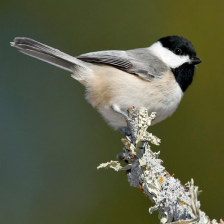

-32.9933
-29.9179
-29.2778
-28.8733
-29.4728
[torch.FloatTensor of size 5]

-28.8733
-29.2778
-29.4728
-29.9179
-32.9933
[torch.FloatTensor of size 5]

 4
 3
 5
 2
 1
[torch.LongTensor of size 5]

[n01592084 chickadee] = 0.99978	
[n01560419 bulbul] = 0.00010	
[n01580077 jay] = 0.00006	
[n01582220 magpie] = 0.00005	
[n01534433 junco, snowbird] = 0.00001	


In [26]:
local input_image = image.load('bird.jpg', 3, 'float') -- make it a float and between 0 and 1.
input_image = image.scale(input_image, 224, 224)  -- resize to the appropriate input for this network.
itorch.image(input_image)

-- Pre-process the image channel by channel.
function preprocess(im)
    local output_image = image.scale(im:clone(), 224, 224)
    for i = 1, 3 do -- channels
        output_image[{{i},{},{}}]:add(-meanStd.mean[i])
        output_image[{{i},{},{}}]:div(meanStd.std[i])
    end
    return output_image
end

input_image = preprocess(input_image):view(1, 3, 224, 224) -- put it in batch form by adding another dimension.

local predictions = model:forward(input_image)
print(predictions[1][{{1,5}}])
print(predictions[1][{{1,5}}]:sort(true))
-- Remember that the last layer is a LogSoftMax so we need to exp() that.
local scores, classIds = predictions[1]:exp():sort(true) 

for i = 1, 5 do
    print(('[%s] = %.5f'):format(imagenetClasses[classIds[i]], scores[i]))
end

In [9]:
function compute_features(input_images)
    -- Create a tensor to hold the feature vectors.
    local features = torch.FloatTensor(input_images:size(1), 4096):zero()
    local batch_size = 250   -- Let's process images in groups of 128.
    for i = 1, input_images:size(1) / batch_size do
        local batchTensor = torch.FloatTensor(batch_size, 3, 224, 224)
        for j = 1, batch_size do
            local im = input_images[(i - 1) * batch_size + j]
            batchTensor[j] = preprocess(im)
        end
        -- Pass the pre-processed images through the network but discard the predictions.
        model:forward(batchTensor)
        -- Store the intermediate results from the layer before the prediction layer.
        for j = 1, batch_size do
            features[(i - 1) * batch_size + j] = model:get(2):get(9).output[j]
        end
        print(('%d. Features computed for %d out of %d images'):format(i, i * batch_size, input_images:size(1)))
    end
    return features
end

local train_images = trainset.data:float():div(255)
local val_images = valset.data:float():div(255)
features = {}
features.train_features = compute_features(train_images)
features.val_features = compute_features(val_images)
torch.save('alexnet_features.t7', features)  -- just in case this notebook gets closed.

/root/torch/install/share/lua/5.1/torch/Tensor.lua:240: $ Torch: not enough memory: you tried to allocate 0GB. Buy new RAM! at /root/torch/pkg/torch/lib/TH/THGeneral.c:226
stack traceback:
	[C]: in function 'resize'
	/root/torch/install/share/lua/5.1/torch/Tensor.lua:240: in function 'float'
	[string "function compute_features(input_images)..."]:22: in main chunk
	[C]: in function 'xpcall'
	/root/torch/install/share/lua/5.1/itorch/main.lua:209: in function </root/torch/install/share/lua/5.1/itorch/main.lua:173>
	/root/torch/install/share/lua/5.1/lzmq/poller.lua:75: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:307: in function 'poll'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:325: in function 'sleep_ex'
	/root/torch/install/share/lua/5.1/lzmq/impl/loop.lua:370: in function 'start'
	/root/torch/install/share/lua/5.1/itorch/main.lua:381: in main chunk
	[C]: in function 'require'
	(command line):1: in main chunk
	[C]: at 0x00406670: 

# Question1
| Model        | Accuracy           | Loss  |
| ------------- | ------------- | ----- |
| 2-layer Nerual net | 0.4925   |  1.436036 |
| CNN | 0.5898 |    1.039071 |
| CNN with BatchNorm | 0.6308 |    0.925501 |
| Intermediate Network Outputs* | N/A |  N/A |
| Fine-tuning the Network* | N/A |  N/A |

*My Mac Air does not have enough computation power to run this.

# Question2
The visualization of the convolutional filters before and after is generated using the code below. I trained the model for 5 epochs.

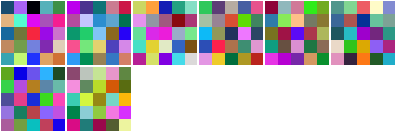

train epoch=1, iteration=100, avg-loss=8789357.401176, avg-accuracy = 0.11	


train epoch=1, iteration=200, avg-loss=4394679.852180, avg-accuracy = 0.11	


train epoch=1, iteration=300, avg-loss=2929787.335810, avg-accuracy = 0.11	


train epoch=1, iteration=400, avg-loss=2197341.077599, avg-accuracy = 0.10	


train epoch=1, iteration=500, avg-loss=1757873.322745, avg-accuracy = 0.10	


train epoch=1, iteration=600, avg-loss=1464894.819421, avg-accuracy = 0.10	


train epoch=1, iteration=700, avg-loss=1255624.460017, avg-accuracy = 0.10	


train epoch=1, iteration=800, avg-loss=1098671.690484, avg-accuracy = 0.10	


train epoch=1, iteration=900, avg-loss=976597.314033, avg-accuracy = 0.10	


train epoch=1, iteration=1000, avg-loss=878937.812959, avg-accuracy = 0.10	


train epoch=1, iteration=1100, avg-loss=799034.584853, avg-accuracy = 0.10	


train epoch=1, iteration=1200, avg-loss=732448.561380, avg-accuracy = 0.10	


train epoch=1, iteration=1300, avg-loss=676106.541544, avg-accuracy = 0.10	


train epoch=1, iteration=1400, avg-loss=627813.381664, avg-accuracy = 0.10	


train epoch=1, iteration=1500, avg-loss=585959.309812, avg-accuracy = 0.10	



validation accuracy at epoch = 1 is 0.0984	


train epoch=2, iteration=100, avg-loss=2.303924, avg-accuracy = 0.10	


train epoch=2, iteration=200, avg-loss=2.303965, avg-accuracy = 0.10	


train epoch=2, iteration=300, avg-loss=2.303556, avg-accuracy = 0.10	


train epoch=2, iteration=400, avg-loss=2.303457, avg-accuracy = 0.10	


train epoch=2, iteration=500, avg-loss=2.303506, avg-accuracy = 0.10	


train epoch=2, iteration=600, avg-loss=2.303432, avg-accuracy = 0.10	


train epoch=2, iteration=700, avg-loss=2.303326, avg-accuracy = 0.10	


train epoch=2, iteration=800, avg-loss=2.303394, avg-accuracy = 0.10	


train epoch=2, iteration=900, avg-loss=2.303270, avg-accuracy = 0.10	


train epoch=2, iteration=1000, avg-loss=2.303311, avg-accuracy = 0.10	


train epoch=2, iteration=1100, avg-loss=2.303393, avg-accuracy = 0.10	


train epoch=2, iteration=1200, avg-loss=2.303367, avg-accuracy = 0.10	


train epoch=2, iteration=1300, avg-loss=2.303377, avg-accuracy = 0.10	


train epoch=2, iteration=1400, avg-loss=2.303390, avg-accuracy = 0.10	


train epoch=2, iteration=1500, avg-loss=2.303315, avg-accuracy = 0.10	



validation accuracy at epoch = 2 is 0.0970	


train epoch=3, iteration=100, avg-loss=2.303240, avg-accuracy = 0.11	


train epoch=3, iteration=200, avg-loss=2.303561, avg-accuracy = 0.10	


train epoch=3, iteration=300, avg-loss=2.303488, avg-accuracy = 0.10	


train epoch=3, iteration=400, avg-loss=2.303523, avg-accuracy = 0.10	


train epoch=3, iteration=500, avg-loss=2.303602, avg-accuracy = 0.10	


train epoch=3, iteration=600, avg-loss=2.303376, avg-accuracy = 0.10	


train epoch=3, iteration=700, avg-loss=2.303273, avg-accuracy = 0.10	


train epoch=3, iteration=800, avg-loss=2.303331, avg-accuracy = 0.10	


train epoch=3, iteration=900, avg-loss=2.303311, avg-accuracy = 0.10	


train epoch=3, iteration=1000, avg-loss=2.303434, avg-accuracy = 0.10	


train epoch=3, iteration=1100, avg-loss=2.303401, avg-accuracy = 0.10	


train epoch=3, iteration=1200, avg-loss=2.303442, avg-accuracy = 0.10	


train epoch=3, iteration=1300, avg-loss=2.303402, avg-accuracy = 0.10	


train epoch=3, iteration=1400, avg-loss=2.303374, avg-accuracy = 0.10	


train epoch=3, iteration=1500, avg-loss=2.303293, avg-accuracy = 0.10	



validation accuracy at epoch = 3 is 0.1044	


train epoch=4, iteration=100, avg-loss=2.303089, avg-accuracy = 0.10	


train epoch=4, iteration=200, avg-loss=2.303016, avg-accuracy = 0.10	


train epoch=4, iteration=300, avg-loss=2.303308, avg-accuracy = 0.10	


train epoch=4, iteration=400, avg-loss=2.303043, avg-accuracy = 0.10	


train epoch=4, iteration=500, avg-loss=2.303180, avg-accuracy = 0.10	


train epoch=4, iteration=600, avg-loss=2.303062, avg-accuracy = 0.10	

train epoch=4, iteration=700, avg-loss=2.303045, avg-accuracy = 0.10	


train epoch=4, iteration=800, avg-loss=2.303107, avg-accuracy = 0.10	


train epoch=4, iteration=900, avg-loss=2.303169, avg-accuracy = 0.10	


train epoch=4, iteration=1000, avg-loss=2.303171, avg-accuracy = 0.10	


train epoch=4, iteration=1100, avg-loss=2.303065, avg-accuracy = 0.10	


train epoch=4, iteration=1200, avg-loss=2.303135, avg-accuracy = 0.10	


train epoch=4, iteration=1300, avg-loss=2.303165, avg-accuracy = 0.10	


train epoch=4, iteration=1400, avg-loss=2.303183, avg-accuracy = 0.10	


train epoch=4, iteration=1500, avg-loss=2.303190, avg-accuracy = 0.10	



validation accuracy at epoch = 4 is 0.1007	


train epoch=5, iteration=100, avg-loss=2.303033, avg-accuracy = 0.10	


train epoch=5, iteration=200, avg-loss=2.303252, avg-accuracy = 0.10	


train epoch=5, iteration=300, avg-loss=2.303247, avg-accuracy = 0.10	


train epoch=5, iteration=400, avg-loss=2.303230, avg-accuracy = 0.10	


train epoch=5, iteration=500, avg-loss=2.303325, avg-accuracy = 0.10	


train epoch=5, iteration=600, avg-loss=2.303338, avg-accuracy = 0.10	


train epoch=5, iteration=700, avg-loss=2.303289, avg-accuracy = 0.10	


train epoch=5, iteration=800, avg-loss=2.303404, avg-accuracy = 0.10	


train epoch=5, iteration=900, avg-loss=2.303398, avg-accuracy = 0.10	


train epoch=5, iteration=1000, avg-loss=2.303403, avg-accuracy = 0.10	


train epoch=5, iteration=1100, avg-loss=2.303369, avg-accuracy = 0.10	


train epoch=5, iteration=1200, avg-loss=2.303422, avg-accuracy = 0.10	


train epoch=5, iteration=1300, avg-loss=2.303419, avg-accuracy = 0.10	


train epoch=5, iteration=1400, avg-loss=2.303405, avg-accuracy = 0.10	

train epoch=5, iteration=1500, avg-loss=2.303389, avg-accuracy = 0.10	



validation accuracy at epoch = 5 is 0.1023	


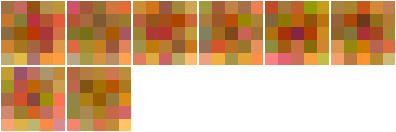

In [8]:
local model = nn.Sequential()
model:add(nn.SpatialConvolution(3, 8, 5, 5))  -- 3 input channels, 8 output channels (8 filters), 5x5 kernels.
model:add(nn.ReLU())
model:add(nn.SpatialMaxPooling(2, 2, 2, 2)) -- Max pooling in 2 x 2 area.
model:add(nn.SpatialConvolution(8, 16, 5, 5))  -- 8 input channels, 16 output channels (16 filters), 5x5 kernels.
model:add(nn.ReLU())                      
model:add(nn.SpatialMaxPooling(2, 2, 2, 2))  -- Max pooling in 2 x 2 area.
model:add(nn.View(16*5*5))   -- Vectorize the output of the convolutional layers.
model:add(nn.Linear(16*5*5, 120))
model:add(nn.ReLU())
model:add(nn.Linear(120, 84))
model:add(nn.ReLU())  
model:add(nn.Linear(84, 10))
model:add(nn.LogSoftMax())

opt = {}
opt.learningRate = 0.01 -- bigger learning rate worked best for this network.
opt.batchSize = 32  -- smaller batch size, less accurate gradients, but more frequent updates.
opt.numEpochs = 5

local filters_before = {}
for i = 1,8 do
    local original = model:get(1).weight[i]
    local max, min = original:max(), original:min()
    original:add(-min):mul(256/(max - min))
    filters_before[i] = image.scale(original, 64, 64, 'simple')
end
itorch.image(filters_before)

trainModel(model, opt)

local filters_after = {}
for i = 1,8 do
    local original = model:get(1).weight[i]
    local max, min = original:max(), original:min()
    original:add(-min):mul(256/(max - min))
    filters_after[i] = image.scale(original, 64, 64, 'simple')
end
itorch.image(filters_after)


# Question3
The convolutional filters for the pretrained AlexNet model are visualized as follows.

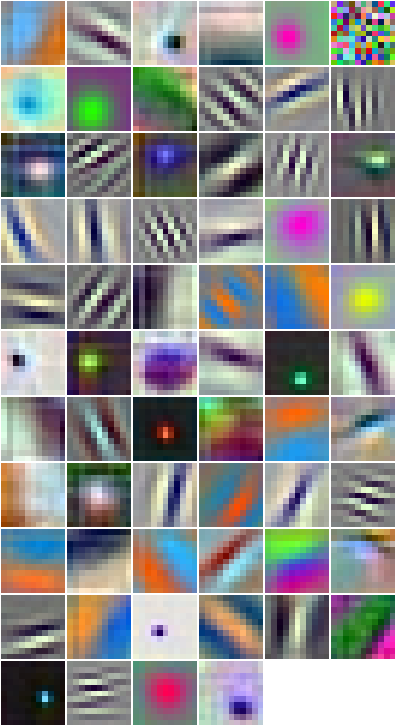

In [133]:
-- Load the model.
model = torch.load('alexnetowtbn_epoch55_cpu.t7')
model:evaluate()  -- Turn on evaluate mode. This is important for layers like BatchNorm or Dropout!
pretrained_filters = {}
for i = 1,64 do    
    local original = model:get(1):get(1).weight[i]
    local max, min = original:max(), original:min()
    original:add(-min):mul(256/(max - min))
    pretrained_filters[i] = image.scale(original, 64, 64, 'simple')
end
itorch.image(pretrained_filters)


In [179]:
local model_1 = nn.Sequential()
-- model_1:add(nn.SpatialConvolution(256, 256, 3, 3, 1, 1, 1, 1))
model_1:add(nn.LogSoftMax(4096, 1000))
torch.save('test.t7', model_1)

# Question4
I get the size of each layer, I put each layer into a Sequential container and save this single layer model to a local file and then record the size. I think there is definitely better ways to do this. I was not able to find a way to query the file size in torch so I just chose to do it manually. The results I get are as follows. From the results, most space is occupied by the Linear layers.

| Model        | Type    | Size  |
| ------------- | ------------- | ----- |
| 1.1 | SpatialConvolution |  158KB |
| 1.2 | SpatialBatchNormalization |    133B |
| 1.3 | ReLU |    133B |
| 1.4 | SpatialMaxPooling  |  620B |
| 1.5 | SpatialConvolution | 2.5MB |
| 1.6 | SpatialBatchNormalization |    133B |
| 1.7 | ReLU   |  133B |
| 1.8 | SpatialMaxPooling | 620B |
| 1.9 | SpatialConvolution |    5.3MB |
| 1.10 | SpatialBatchNormalization   |  133B |
| 1.11 | ReLU | 133B |
| 1.12 | SpatialConvolution |    7.1MB |
| 1.13 | SpatialBatchNormalization   |  133B |
| 1.14 | ReLU | 133B |
| 1.15 | SpatialConvolution |    4.7MB |
| 1.16 | SpatialBatchNormalization   |  133B |
| 1.17 | ReLU | 133B |
| 1.18 | SpatialMaxPooling |    620B |
| 2.1 | View |  474B |
| 2.2 | Dropout |    506B |
| 2.3 | Linear |    302MB |
| 2.4 | BatchNormalization   |  133B |
| 2.5 | ReLU | 133B |
| 2.6 | Dropout |    506B |
| 2.7 | Linear   |  134.3MB |
| 2.8 | BatchNormalization | 133B |
| 2.9 | ReLU |    133B |
| 2.10 | Linear   |  32.8MB |
| 2.11 | LogSoftMax   |  385B |

# Question5
The input for the first Sequential container is 3 \* 24 \* 24. I will list the dimension of the resulting data after each filter.

1.1 owidth = (224 + 8 -11)/2 + 1 = 111 -> 64 \* 111 \* 111

1.2 64 \* 111 \* 111

1.3 64 \* 111 \* 111

1.4 owidth = (111 - 3)/2 + 1 = 55 -> 64 \* 55 \* 55

1.5 owidth = (55 + 2 - 5)/2 + 1 =27 -> 192 \* 27 \* 27

1.6 192 \* 27 \* 27

1.7 192 \* 27 \* 27

1.8 owidth = (27 - 3)/2 + 1 = 14 -> 192 \* 14 \* 14

1.9 - 1.11 384 \* 14 \* 14

1.12 - 1.17 256 \* 14 \* 14

1.18 owidth = (14 - 3)/2 + 1 = 6 -> 192 \* 6 \* 6 = 9216

The multiplication of the dimemsion should be exactly the same as the size in nn.View.

# Question6
### VGG vs. AlexNet
VGG has more layers than AlexNet. The AlexNet has 5 convolutional layers and 3 maxpooling layer. On the other hand, VGG (type A) has 8 convolutional layers and 3 maxpooling layer. In this case the difference is not substantial. In addition, VGG also use larger convolutional filters.

### GoogLeNet vs. AlexNet
GooLeNet has a LOT more layers than AlexNet, in this case around 80 convolutional layers. On the other hand GooLeNet use smaller convolutional filters than AlexNet. Due to the number of layers, it will also be more expensive to change.

### Memory Usage
From previous analysis we have found out that the Linear layer is contributing to most of the memory usage since it need a value for each pair of entries from input and output. Both VGG and GoogLeNet has 3 Linear layers. However, the largest one from VGG is ~70 times the size of that from GoogLeNet. In this case I would say VGG is more memory-consuming. (I would also say GoogLeNet would take longer to train, thus more time-consuming.)